# Testing rotation period optimisation.

The purpose of this project is to attempt to optimise the measurement of stellar rotation periods from TESS data. This will involve the following stages:

1) Calculate single & double Lomb-Scargle periodograms, ACFs and PDMs of Kepler light curves with and without measured rotation periods (McQuillan et al. 2014).

2) Calculate features/statistics of these: heights and positions of tallest peaks, etc.

3) Train a random forest classifier to classify rotators, non-rotators, and non-periodic rotators.

4) Train a random forest regressor to measure a rotation period from these features.

5) Repeat with Kepler light curves cut into 27 days sectors.

6) Build a training set from TESS CVZ stars.

7) Repeat using this as a training set.

In [8]:
%matplotlib inline

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

First let's just try one star. Load the McQuillan tables.

In [6]:
mc1 = pd.read_csv("../data/Table_1_Periodic.txt")
mc2 = pd.read_csv("../data/Table_2_Non_Periodic.txt")

mc1.head()

,kepid,Teff,logg,Mass,Prot,Prot_err,Rper,LPH,w,DC,Flag
0,892376,3813,4.47,0.4699,1.532,0.007,7306.69,0.823,0.4503,0,---
1,1026146,4261,4.57,0.6472,14.891,0.120,11742.56,1.405,0.7229,0,---
2,1026474,4122,4.56,0.5914,1.569,0.006,30471.80,1.204,0.6061,0,---
3,1162635,3760,4.77,0.4497,15.678,0.019,10207.47,0.978,0.5445,1,---
4,1164102,4045,4.62,0.5606,31.496,0.474,5139.74,0.568,0.3939,0,---


Load the first light curve.

In [14]:
import kepler_data as kd

kplr_path = "/Users/rangus/.kplr/data/lightcurves"
x, y, yerr = kd.load_and_join(os.path.join(kplr_path, str(int(mc1.iloc[0].kepid)).zfill(9)))
inds = np.argsort(x)
x, y, yerr = x[inds], y[inds], yerr[inds]

(131.51271694523166, 231.51271694523166)

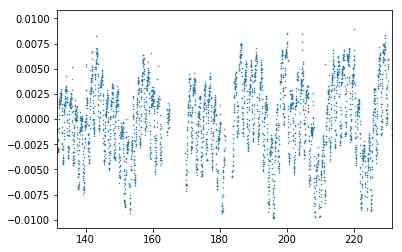

In [22]:
import sigma_clip as sc

_, mask = sc.sigma_clip(y)

# plt.plot(x, y, ".", ms=1)
plt.plot(x[mask], y[mask], ".", ms=1)
plt.xlim(x[0], x[0]+100)

In [23]:
import starrotate as sr

In [29]:
rm = sr.RotationModel(x[mask], y[mask], yerr[mask])

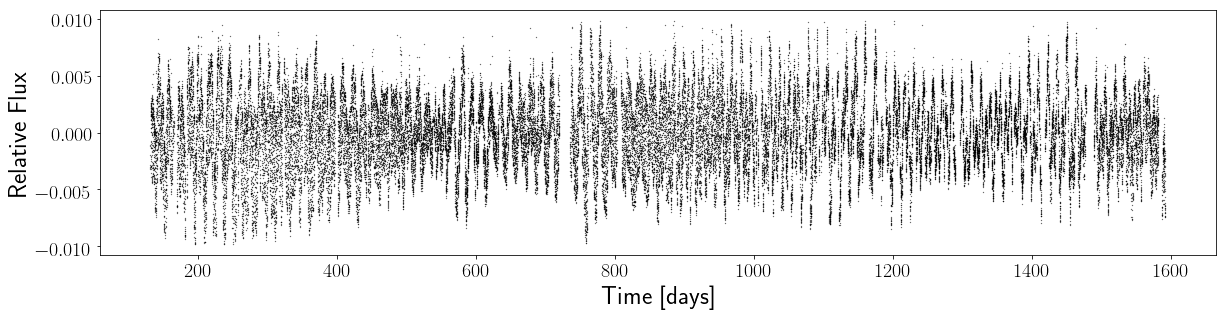

In [30]:
rm.plot_lc()

Calculate LS periodogram and ACF.

In [49]:
highest_peak_period = rm.LS_rotation()
highest_peak_acf = rm.ACF_rotation(interval=0.02043365)

1.5335924517051571 13.8131474


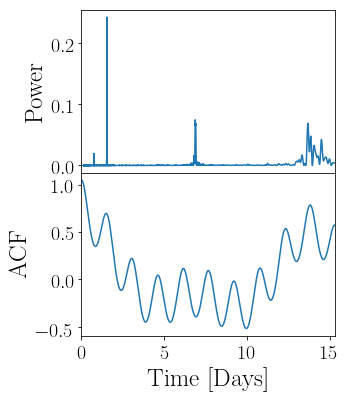

In [75]:
fig = plt.figure(figsize=(5, 6))

ax1 = fig.add_subplot(211)
ax1.plot(1./rm.freq, rm.power)
ax1.set_xlim(0, np.min([10*highest_peak_period, max(1./rm.freq)]))
ax1.set_ylabel("$\mathrm{Power}$")

ax2 = fig.add_subplot(212, sharex=ax1)
ax2.plot(rm.lags, rm.acf)
ax2.set_ylabel("$\mathrm{ACF}$")
ax2.set_xlabel("$\mathrm{Time~[Days]}$")

plt.subplots_adjust(hspace=0, right=0.83)
plt.setp(ax1.get_xticklabels(), visible=False);

Calculate some statistics. Ideas:

Lomb-Scargle

1) Peak position
 
2) Peak height

3) Peak 2 position

4) Peak 2 height

5) Peak 3 position

6) Peak 3 height

7) RMS?

8) MAD


ACF

1) Max peak height

2) Max peak position

3) First peak height

4) First peak position

5) 2nd peak height

6) 2nd peak position

Light curve:

1) Rvar

2) Rvar_10day

3) Rvar_20day

4) Rvar_50_day

Define a function for calculating peak statistics.

In [225]:
def get_peak_statistics(x, y):
    
    # Array of peak indices
    peaks = np.array([i for i in range(1, len(y)-1) if y[i-1] < 
                      y[i] and y[i+1] < y[i]])
    
    # extract peak values
    x_peaks = x[peaks]
    y_peaks = y[peaks]
    
    # sort by height
    inds = np.argsort(y_peaks)
    x_peaks1, y_peaks1 = x_peaks[inds][::-1], y_peaks[inds][::-1]
    
    # sort by position
    inds2 = np.argsort(x_peaks)
    x_peaks2, y_peaks2 = x_peaks[inds2], y_peaks[inds2]
    
    return x_peaks1, y_peaks1, x_peaks2, y_peaks2

Get statistics.

In [236]:
# Highest 3 peak heights and positions in the LS periodogram
peak_periods1, peak_powers1, _, _ = get_peak_statistics(1./rm.freq, rm.power)
ls_height3 = peak_powers1[:3]
ls_position3 = peak_periods1[:3]
ls_mad = np.median(np.abs(rm.power))
ls_rms = np.sqrt(np.mean(rm.power**2))

# Highest and first 3 peak heights and positions in the LS periodogram
lags1, acf1, lags2, acf2 = get_peak_statistics(rm.lags, rm.acf)
acf_h3_height = acf1[:3]
acf_h3_pos = lags1[:3]
acf_1st3_height = acf2[:3]
acf_1st3_pos = lags2[:3]

# Calculate periodogram of ACF
from astropy.timeseries import LombScargle
acf_freqs = np.linspace(1./100, 1./.1, 10000)
acf_pgram = LombScargle(rm.lags, rm.acf).power(acf_freqs)
acf_ls_periods, acf_ls_powers, _, _ = get_peak_statistics(1./acf_freqs, acf_pgram)
acf_ls_h3, acf_ls_p3 = acf_ls_powers[:3], acf_ls_periods[:3]

acf_mad = np.median(np.abs(rm.acf))
acf_rms = np.sqrt(np.mean(rm.acf**2))

Rvar = np.percentile(y, 95) - np.percentile(y, 5)
Rvar

0.01081782281398773

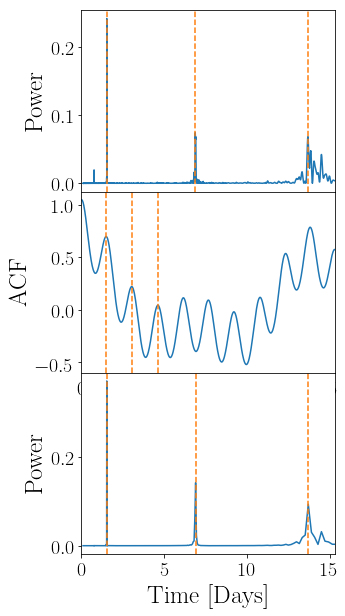

In [240]:
fig = plt.figure(figsize=(5, 10))

ax1 = fig.add_subplot(311)
ax1.plot(1./rm.freq, rm.power)
ax1.set_xlim(0, np.min([10*highest_peak_period, max(1./rm.freq)]))
ax1.set_ylabel("$\mathrm{Power}$")
ax1.axvline(ls_position3[0], color="C1", ls="--")
ax1.axvline(ls_position3[1], color="C1", ls="--")
ax1.axvline(ls_position3[2], color="C1", ls="--")

ax2 = fig.add_subplot(312, sharex=ax1)
ax2.plot(rm.lags, rm.acf)
ax2.set_ylabel("$\mathrm{ACF}$")
ax2.axvline(acf_1st3_pos[0], color="C1", ls="--")
ax2.axvline(acf_1st3_pos[1], color="C1", ls="--")
ax2.axvline(acf_1st3_pos[2], color="C1", ls="--")

ax3 = fig.add_subplot(313, sharex=ax1)
ax3.plot(1./acf_freqs, acf_pgram)
ax3.axvline(acf_ls_p3[0], color="C1", ls="--")
ax3.axvline(acf_ls_p3[1], color="C1", ls="--")
ax3.axvline(acf_ls_p3[2], color="C1", ls="--")
ax3.set_ylabel("$\mathrm{Power}$")

ax3.set_xlabel("$\mathrm{Time~[Days]}$")
plt.subplots_adjust(hspace=0, right=0.83)
plt.setp(ax1.get_xticklabels(), visible=False);

In [241]:
print(ls_position3[0], acf_1st3_pos[0], acf_ls_p3[0])

1.5335924517051571 1.49165645 1.5327520556260694


Calculate ACF statistics.

In [217]:
lags1, acf1, lags2, acf2 = get_peak_statistics(rm.lags, rm.acf)

mad_acf = np.median(np.abs(rm.acf))
rms_acf = np.sqrt(np.mean(rm.acf**2))

print(mad_acf, rms_acf)

0.09101046659302944 0.14698950814043688


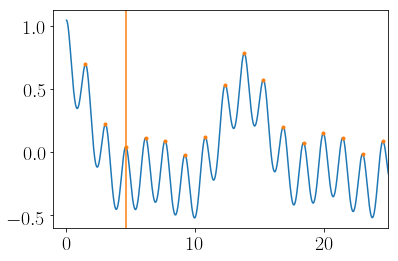

In [218]:
plt.plot(rm.lags, rm.acf)
plt.xlim(-1, 25)
plt.plot(lags2, acf2, ".")
plt.axvline(lags2[2], color="C1")

In [219]:
# Calculate periodogram of ACF
from astropy.timeseries import LombScargle

acf_freqs = np.linspace(1./100, 1./.1, 10000)
acf_pgram = LombScargle(rm.lags, rm.acf).power(acf_freqs)

acf_ls_periods, acf_ls_powers, _, _ = get_peak_statistics(1./acf_freqs, acf_pgram)

(0, 25)

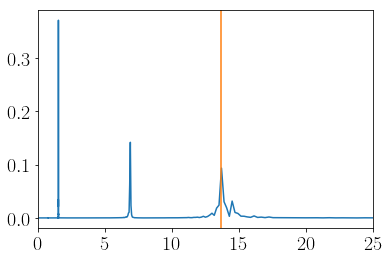

In [220]:
plt.plot(1./acf_freqs, acf_pgram)
plt.axvline(acf_ls_periods[2], color="C1")
plt.xlim(0, 25)

In [221]:
print(acf_ls_periods[:2])

[1.53275206 6.90233598]


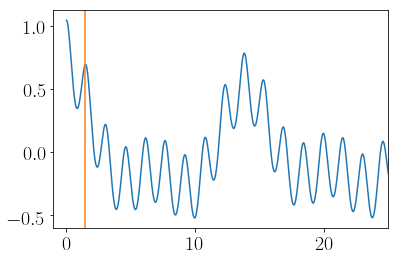

In [224]:
plt.plot(rm.lags, rm.acf)
plt.xlim(-1, 25)
plt.axvline(lags2[0], color="C1")